## 1. サマリーしたデータを読み込んで可視化する
前のステップで処理したデータはS3バケットに格納されているので、Notebook内に読み込んで可視化するところから始めます  

In [2]:
import awswrangler as wr
import pandas as pd
import boto3

In [25]:
bucket = 'tuki-bkt-misc'
prefix = 'data/nyctaxi/daily_w_location'

In [232]:
s3 = boto3.client('s3')
response = s3.list_objects(Bucket=bucket, Prefix=prefix)
nyctaxi_summary_files = sorted([x['Key'] for x in response['Contents']])
nyctaxi_summary_files = [x for x in nyctaxi_summary_files if ('green' in x) and ('2019' in x or '2020' in x)]
nyctaxi_summary_files

['data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190101.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190102.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190103.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190104.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190105.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190106.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190107.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190108.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190109.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190110.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190111.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190112.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190113.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190114.csv',
 'data/nyctaxi/daily

blog執筆時点では、2019年1月1日から約1年半分のデータが取得できています。読み込み処理には数分かかります。

In [233]:
df_data = pd.DataFrame()
for file in nyctaxi_summary_files:
    df_read = wr.s3.read_csv(f's3://{bucket}/{file}')
    df_data = pd.concat([df_data, df_read])

In [234]:
print('Number of records:', df_data.shape[0])

Number of records: 1157445


それでは、読み込んだデータをプロットします。

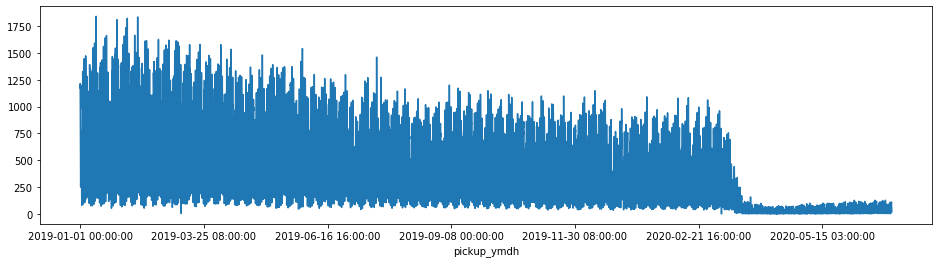

In [235]:
df_data.groupby(by='pickup_ymdh')['count'].sum().plot(figsize=(16,4))

2019年1月から漸減傾向ながらもピーク時に1000を超える程度の数値で推移していた「1時間あたりのgreenタクシーピックアップ数」が、2020年の4月前後から顕著に少なくなっていることが読み取れます。COVID-19の影響でNew Yorkにおいてもロックダウンが実施されたため、それによる外出の減少がタクシーの需要にも大きな影響を及ぼしたことがわかります。COVID-19の影響によるデータドリフトが、タクシー需要に現れているとも言えます。  
ここからは、タクシー需要を予測するモデルを運用していたときに、Model Monitorによってデータ傾向を監視していたとしたらどのような指標の変化が現れるのか、どのようにして変化を検出できるのか、を見ていきましょう。  

## 2. タクシー需要の予測モデルを構築する
まず簡易な予測モデルを作成して、タクシー需要を予測します。ここではXGBoostを使用して、自己回帰に近いモデルを作成しています。  
ここまでのステップで2019年1月からのデータを取得しているので、「2019年1月から12月までのデータを用いてモデルを構築し、2020年1月からモデルの運用を開始した」とします。
つまり、モデルの運用から約3ヶ月間は平常状態で、4ヶ月後にデータドリフトに直面することになります。

In [202]:
g = df_data.groupby(by='pickup_ymdh')

df_features = pd.DataFrame()
df_features['y'] = g['count'].sum()
df_features['time_hh'] = df_features.index.strftime('%H')
df_features['count_m1h'] = df_features.y.shift(1)
df_features['count_m2h'] = df_features.y.shift(2)
df_features['count_m3h'] = df_features.y.shift(3)
df_features['count_m4h'] = df_features.y.shift(4)
df_features['count_m24h'] = df_features.y.shift(24)
df_features['count_m1w'] = df_features.y.shift(168)
df_features['weekday'] = df_features.index.strftime('%w')
df_features.head(25)

,y,time_hh,count_m1h,count_m2h,count_m3h,count_m4h,count_m24h,count_m1w,weekday
pickup_ymdh,,,,,,,,,
2018-01-01 00:00:00,2231,00,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-01-01 01:00:00,2271,01,2231.0,NaN,NaN,NaN,NaN,NaN,1
2018-01-01 02:00:00,1932,02,2271.0,2231.0,NaN,NaN,NaN,NaN,1
2018-01-01 03:00:00,1694,03,1932.0,2271.0,2231.0,NaN,NaN,NaN,1
2018-01-01 04:00:00,1316,04,1694.0,1932.0,2271.0,2231.0,NaN,NaN,1
2018-01-01 05:00:00,766,05,1316.0,1694.0,1932.0,2271.0,NaN,NaN,1
2018-01-01 06:00:00,485,06,766.0,1316.0,1694.0,1932.0,NaN,NaN,1
2018-01-01 07:00:00,409,07,485.0,766.0,1316.0,1694.0,NaN,NaN,1
2018-01-01 08:00:00,369,08,409.0,485.0,766.0,1316.0,NaN,NaN,1


In [203]:
mean_by_hh = df_features.groupby(by='time_hh').y.mean().rename('mean_by_hh')
df_features = df_features.reset_index()
df_features = pd.merge(df_features, mean_by_hh, how='left', on='time_hh')
df_features = df_features.set_index('pickup_ymdh')
df_features

,y,time_hh,count_m1h,count_m2h,count_m3h,count_m4h,count_m24h,count_m1w,weekday,mean_by_hh
pickup_ymdh,,,,,,,,,,
2018-01-01 00:00:00,2231,00,NaN,NaN,NaN,NaN,NaN,NaN,1,472.333333
2018-01-01 01:00:00,2271,01,2231.0,NaN,NaN,NaN,NaN,NaN,1,339.794956
2018-01-01 02:00:00,1932,02,2271.0,2231.0,NaN,NaN,NaN,NaN,1,239.623491
2018-01-01 03:00:00,1694,03,1932.0,2271.0,2231.0,NaN,NaN,NaN,1,192.806593
2018-01-01 04:00:00,1316,04,1694.0,1932.0,2271.0,2231.0,NaN,NaN,1,170.334430
...,...,...,...,...,...,...,...,...,...,...
2020-06-30 19:00:00,81,19,96.0,112.0,97.0,104.0,82.0,83.0,2,1063.729167
2020-06-30 20:00:00,41,20,81.0,96.0,112.0,97.0,52.0,53.0,2,893.576754
2020-06-30 21:00:00,24,21,41.0,81.0,96.0,112.0,24.0,28.0,2,810.742325


モデルの構築に利用できるのは2019年中のデータなので、2019年1月から8月までのデータをトレーニング、9月と10月のデータをバリデーション, 11月と12月のデータをテスト用に使用します。  
Amazon SageMakerが提供するXGBoostアルゴリズムはS3からデータを取得して動作するので、分離したデータをS3に保管します。  

In [236]:
df_train = df_features[(df_features.index >= '2019-02-01') & (df_features.index < '2019-09-01')]
df_validation = df_features[(df_features.index >= '2019-09-01') & (df_features.index < '2019-11-01')]
df_test = df_features[(df_features.index >= '2019-11-01') & (df_features.index < '2020-01-01')]
model_data_prefix = 'data/nyctaxi/model_training'
train_data_path = f's3://{bucket}/{model_data_prefix}/data.train'
validation_data_path = f's3://{bucket}/{model_data_prefix}/data.validation'

wr.s3.to_csv(df_train, train_data_path, index=False, header=False)
wr.s3.to_csv(df_validation, validation_data_path, index=False, header=False)

{'paths': ['s3://tuki-bkt-misc/data/nyctaxi/model_training/data.validation'],
 'partitions_values': {}}

In [238]:
print('Training data:', df_train.shape[0])
print('Validation data:', df_validation.shape[0])
print('Test data:', df_test.shape[0])

Training data: 5088
Validation data: 1464
Test data: 1464


In [207]:
from sagemaker.amazon.amazon_estimator import get_image_uri

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
container = get_image_uri(region, 'xgboost', '1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [239]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'xgboost-regression-nyctaxi-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_prefix = 'model/xgboost-regression-nyctaxi'
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": f's3://{bucket}/{model_prefix}'
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m5.large",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"20",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "silent":"0",
        "objective":"reg:linear",
        "num_round":"50"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_data_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": validation_data_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}


client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job xgboost-regression-nyctaxi-2020-09-13-18-27-41
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 72.2 ms, sys: 4.54 ms, total: 76.8 ms
Wall time: 4min 1s


In [229]:
%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

xgboost-regression-nyctaxi-2020-09-09-06-58-09-model
s3://tuki-bkt-misc/model/xgboost-regression-nyctaxi/xgboost-regression-nyctaxi-2020-09-09-06-58-09/output/model.tar.gz
arn:aws:sagemaker:ap-northeast-1:896540033301:model/xgboost-regression-nyctaxi-2020-09-09-06-58-09-model
CPU times: user 7.25 ms, sys: 0 ns, total: 7.25 ms
Wall time: 476 ms


モデルのトレーニングが終わったので、これをEndpointにデプロイします。  

In [240]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-09-13-18-37-30
Endpoint Config Arn: arn:aws:sagemaker:ap-northeast-1:896540033301:endpoint-config/demo-xgboostendpointconfig-2020-09-13-18-37-30


In [241]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
while status=='Creating':
    print("Status: " + status)
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-09-13-18-37-31
arn:aws:sagemaker:ap-northeast-1:896540033301:endpoint/demo-xgboostendpoint-2020-09-13-18-37-31
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Arn: arn:aws:sagemaker:ap-northeast-1:896540033301:endpoint/demo-xgboostendpoint-2020-09-13-18-37-31
Status: InService
CPU times: user 104 ms, sys: 7.91 ms, total: 112 ms
Wall time: 8min 1s


## 3. 作成したモデルの精度を検証する

In [213]:
import numpy as np
import json
import math

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)

In [216]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

def list_to_libsvm(value_list):
    payload = ''
    for i, value in enumerate(value_list):
        payload = payload + f' {i+1}:{value}'

    return payload[1:]

def call_model_endpoint(endpoint_name, payload):
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='text/x-libsvm', 
                                       Body=payload)
    result = response['Body'].read().decode("utf-8")
    result = result.split(',')
    result = [math.ceil(float(i)) for i in result]
    return result[0]

def exec_prediction(df):
    all_pred = []
    for i, row in df.iterrows():
        payload = list_to_libsvm(row[1:])
        prediction = call_model_endpoint(endpoint_name, payload)
        all_pred.append(prediction)
        
    return all_pred

In [218]:
payload = list_to_libsvm(df_test.values[0, 1:].tolist())
payload

'1:00 2:528.0 3:612.0 4:762.0 5:740.0 6:275.0 7:435.0 8:6 9:472.3333333333333'

In [219]:
df_test['pred'] = exec_prediction(df_test)

In [220]:
df_test.head(10)

,y,time_hh,count_m1h,count_m2h,count_m3h,count_m4h,count_m24h,count_m1w,weekday,mean_by_hh,pred
pickup_ymdh,,,,,,,,,,,
2020-02-01 00:00:00,460,00,528.0,612.0,762.0,740.0,275.0,435.0,6,472.333333,274
2020-02-01 01:00:00,337,01,460.0,528.0,612.0,762.0,155.0,373.0,6,339.794956,174
2020-02-01 02:00:00,277,02,337.0,460.0,528.0,612.0,97.0,287.0,6,239.623491,127
2020-02-01 03:00:00,207,03,277.0,337.0,460.0,528.0,69.0,229.0,6,192.806593,100
2020-02-01 04:00:00,162,04,207.0,277.0,337.0,460.0,71.0,187.0,6,170.334430,88
2020-02-01 05:00:00,82,05,162.0,207.0,277.0,337.0,80.0,91.0,6,141.789474,88
2020-02-01 06:00:00,77,06,82.0,162.0,207.0,277.0,134.0,88.0,6,252.031798,118
2020-02-01 07:00:00,145,07,77.0,82.0,162.0,207.0,406.0,178.0,6,510.800439,271
2020-02-01 08:00:00,258,08,145.0,77.0,82.0,162.0,618.0,313.0,6,773.395833,343


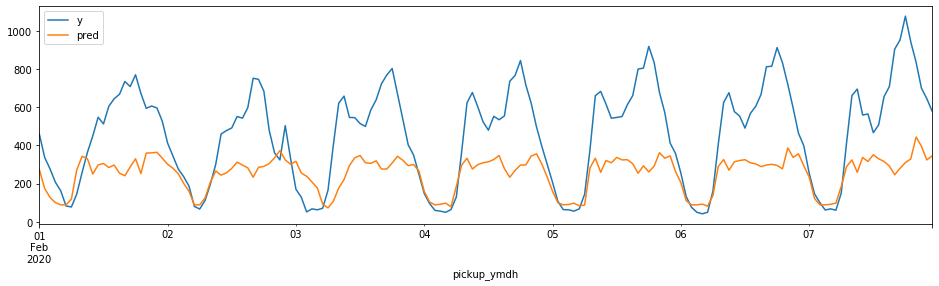

In [221]:
df_test[:168].plot(y=['y', 'pred'], figsize=(16,4))

In [222]:
df_t1 = df_validation.copy()
df_t1['pred'] = exec_prediction(df_t1)
df_t1.head(10)

,y,time_hh,count_m1h,count_m2h,count_m3h,count_m4h,count_m24h,count_m1w,weekday,mean_by_hh,pred
pickup_ymdh,,,,,,,,,,,
2019-10-01 00:00:00,204,00,253.0,371.0,455.0,545.0,212.0,216.0,2,472.333333,201
2019-10-01 01:00:00,127,01,204.0,253.0,371.0,455.0,121.0,131.0,2,339.794956,103
2019-10-01 02:00:00,81,02,127.0,204.0,253.0,371.0,87.0,74.0,2,239.623491,93
2019-10-01 03:00:00,74,03,81.0,127.0,204.0,253.0,67.0,52.0,2,192.806593,88
2019-10-01 04:00:00,73,04,74.0,81.0,127.0,204.0,92.0,62.0,2,170.334430,97
2019-10-01 05:00:00,82,05,73.0,74.0,81.0,127.0,77.0,74.0,2,141.789474,89
2019-10-01 06:00:00,175,06,82.0,73.0,74.0,81.0,162.0,181.0,2,252.031798,174
2019-10-01 07:00:00,393,07,175.0,82.0,73.0,74.0,396.0,446.0,2,510.800439,282
2019-10-01 08:00:00,620,08,393.0,175.0,82.0,73.0,604.0,707.0,2,773.395833,320


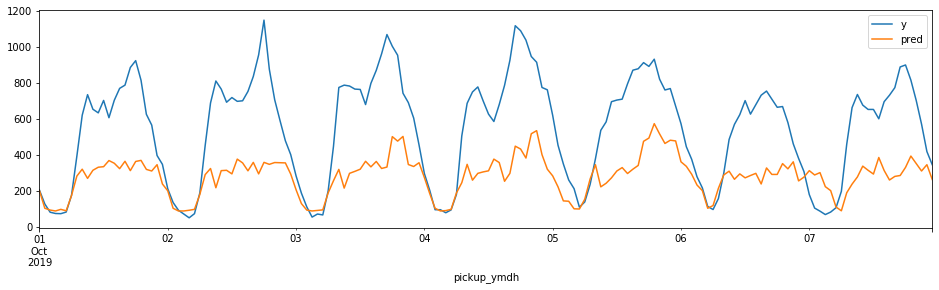

In [223]:
df_t1[:168].plot(y=['y', 'pred'], figsize=(16,4))

In [224]:
df_t2 = df_train.copy()
df_t2['pred'] = exec_prediction(df_t2)
df_t2.head(10)

,y,time_hh,count_m1h,count_m2h,count_m3h,count_m4h,count_m24h,count_m1w,weekday,mean_by_hh,pred
pickup_ymdh,,,,,,,,,,,
2019-02-01 00:00:00,399,00,566.0,741.0,930.0,1104.0,357.0,421.0,5,472.333333,321
2019-02-01 01:00:00,251,01,399.0,566.0,741.0,930.0,175.0,275.0,5,339.794956,171
2019-02-01 02:00:00,147,02,251.0,399.0,566.0,741.0,83.0,181.0,5,239.623491,120
2019-02-01 03:00:00,121,03,147.0,251.0,399.0,566.0,85.0,110.0,5,192.806593,93
2019-02-01 04:00:00,119,04,121.0,147.0,251.0,399.0,82.0,143.0,5,170.334430,88
2019-02-01 05:00:00,142,05,119.0,121.0,147.0,251.0,150.0,174.0,5,141.789474,142
2019-02-01 06:00:00,424,06,142.0,119.0,121.0,147.0,375.0,386.0,5,252.031798,276
2019-02-01 07:00:00,855,07,424.0,142.0,119.0,121.0,844.0,844.0,5,510.800439,239
2019-02-01 08:00:00,1393,08,855.0,424.0,142.0,119.0,1283.0,1277.0,5,773.395833,477


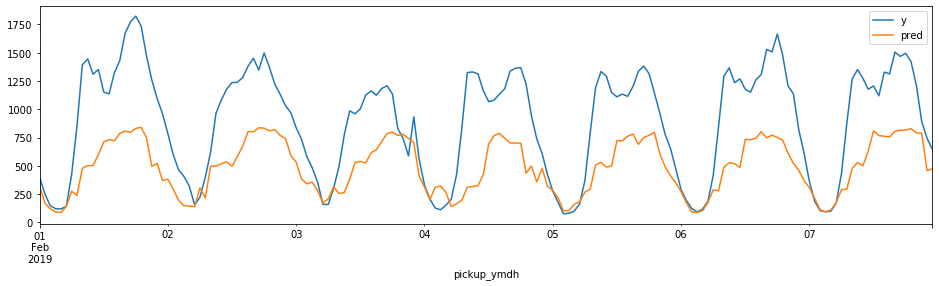

In [225]:
df_t2[:168].plot(y=['y', 'pred'], figsize=(16,4))

## 4. SageMaker Model Monitorを設定する

SageMaker Model Monitorの設定には、  
1. Endpointへ投入された推論データのリアルタイムキャプチャー設定
1. トレーニングデータからのベースラインの作成
1. モニターのスケジュール

の3つのステップがあります。順に見てきましょう  

### 4.1. 推論データキャプチャーの設定

前のステップで作成済みの推論Endpointがあるので、このEndpointを更新します。

In [244]:
# Please fill in the following for enabling data capture
endpoint_name = 'DEMO-XGBoostEndpoint-2020-09-13-18-37-31'
s3_capture_upload_path = 's3://tuki-bkt-misc/model_monitor/endpoint-data-capture/' #example: s3://bucket-name/path/to/endpoint-data-capture/


In [245]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker import session
import boto3
sm_session = session.Session(boto3.Session())

# Change parameters as you would like - adjust sampling percentage, 
#  chose to capture request or response or both.
#  Learn more from our documentation
data_capture_config = DataCaptureConfig(
                        enable_capture = True,
                        sampling_percentage=50,
                        destination_s3_uri=s3_capture_upload_path,
                        kms_key_id=None,
                        capture_options=["REQUEST", "RESPONSE"],
                        csv_content_types=["text/csv"],
                        json_content_types=["application/json"])

# Now it is time to apply the new configuration and wait for it to be applied
predictor = RealTimePredictor(endpoint=endpoint_name)
predictor.update_data_capture_config(data_capture_config=data_capture_config)
sm_session.wait_for_endpoint(endpoint=endpoint_name)

----------------!!

{'EndpointName': 'DEMO-XGBoostEndpoint-2020-09-13-18-37-31',
 'EndpointArn': 'arn:aws:sagemaker:ap-northeast-1:896540033301:endpoint/demo-xgboostendpoint-2020-09-13-18-37-31',
 'EndpointConfigName': 'DEMO-XGBoostEndpoint-2020-09-13-18-37-3-2020-09-13-18-51-03-435',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '354813040037.dkr.ecr.ap-northeast-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
     'ResolvedImage': '354813040037.dkr.ecr.ap-northeast-1.amazonaws.com/sagemaker-xgboost@sha256:b0f7d76963f88f9890bfa3288e256d4cc14308ace32a036f77b977d8cf4319a5',
     'ResolutionTime': datetime.datetime(2020, 9, 13, 18, 51, 37, 85000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 50,
  'DestinationS3Uri': 's3://tuki-bkt-misc/model_monitor/endpoint-data-ca

### 4.2. ベースラインデータの作成

ベースラインを作成するための入力データとして、モデル構築に利用した2019年の乗車データを利用します。

In [276]:
baseline_data_path = f's3://{bucket}/model_monitor/baseline_input/features-2019.csv'
df_data2019 = df_features[(df_features.index >= '2019-01-01') & (df_features.index < '2020-01-01')]
wr.s3.to_csv(df_data2019, baseline_data_path, index=False)

baseline_results_uri = 's3://tuki-bkt-misc/model_monitor/baseline/' ##'s3://bucketname/path/to/baseline/data' - Where the results are to be stored in

print('Baseline data uri: {}'.format(baseline_data_path))
print('Baseline results uri: {}'.format(baseline_results_uri))

Baseline data uri: s3://tuki-bkt-misc/model_monitor/baseline_input/features-2019.csv
Baseline results uri: s3://tuki-bkt-misc/model_monitor/baseline/


In [296]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker import get_execution_role

role = get_execution_role()

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_path,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)


Job Name:  baseline-suggestion-job-2020-09-13-21-01-45-923
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/baseline_input/features-2019.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/baseline/', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................2020-09-13 21:05:46,109 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:ap-northeast-1:896540033301:processing-job/baseline-suggestion-job-2020-09-13-21-01-45-923', 'ProcessingJobName': 'baseline-suggestion-job-2020-09-13-21-01-45-923', 'Environment': {'dataset_format': '{"csv": {"header": true, "output_columns_position": "START"}}', 'dataset_source': '/opt/ml/processing/in

### 生成されたconstraintとstatisticsを確認する

In [297]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,y,Integral,8760,0,633.360046,5.548234e+06,368.997985,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[564.0, 580.0, 610.0, 724.0, 710.0, 817.0, 81..."
1,time_hh,Integral,8760,0,11.500000,1.007400e+05,6.922187,0.000000,23.00000,"[{'lower_bound': 0.0, 'upper_bound': 2.3, 'cou...",0.64,2048.0,"[[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17..."
2,count_m1h,Fractional,8760,0,633.403995,5.548619e+06,369.018246,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[510.0, 564.0, 580.0, 610.0, 724.0, 710.0, 81..."
3,count_m2h,Fractional,8760,0,633.468265,5.549182e+06,369.085826,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[347.0, 510.0, 564.0, 580.0, 610.0, 724.0, 71..."
4,count_m3h,Fractional,8760,0,633.547374,5.549875e+06,369.217405,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[200.0, 347.0, 510.0, 564.0, 580.0, 610.0, 72..."
5,count_m4h,Fractional,8760,0,633.619292,5.550505e+06,369.346217,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[124.0, 200.0, 347.0, 510.0, 564.0, 580.0, 61..."
6,count_m24h,Fractional,8760,0,634.476142,5.558011e+06,369.862759,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[669.0, 587.0, 565.0, 582.0, 656.0, 826.0, 94..."
7,count_m1w,Fractional,8760,0,640.216096,5.608293e+06,370.514116,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[561.0, 563.0, 607.0, 707.0, 683.0, 761.0, 81..."
8,weekday,Integral,8760,0,2.997260,2.625600e+04,1.997942,0.000000,6.00000,"[{'lower_bound': 0.0, 'upper_bound': 0.6, 'cou...",0.64,2048.0,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,..."
9,mean_by_hh,Fractional,8760,0,692.773220,6.068693e+06,317.796370,141.789474,1172.70614,"[{'lower_bound': 141.78947368421052, 'upper_bo...",0.64,2048.0,"[[832.8092105263158, 822.2379385964912, 826.21..."


In [312]:
kll_buckets = schema_df[schema_df.name == 'count_m1h']['numerical_statistics.distribution.kll.buckets'].tolist()[0]
for bucket in kll_buckets:
    print(bucket)

{'lower_bound': 5.0, 'upper_bound': 188.6, 'count': 1538.0}
{'lower_bound': 188.6, 'upper_bound': 372.2, 'count': 937.0}
{'lower_bound': 372.2, 'upper_bound': 555.8, 'count': 1019.0}
{'lower_bound': 555.8, 'upper_bound': 739.4, 'count': 1789.0}
{'lower_bound': 739.4, 'upper_bound': 923.0, 'count': 1560.0}
{'lower_bound': 923.0, 'upper_bound': 1106.6, 'count': 943.0}
{'lower_bound': 1106.6, 'upper_bound': 1290.2, 'count': 602.0}
{'lower_bound': 1290.2, 'upper_bound': 1473.8, 'count': 286.0}
{'lower_bound': 1473.8, 'upper_bound': 1657.4, 'count': 74.0}
{'lower_bound': 1657.4, 'upper_bound': 1841.0, 'count': 12.0}


In [298]:
constraints_df = pd.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,name,inferred_type,completeness,num_constraints.is_non_negative
0,y,Integral,1.0,True
1,time_hh,Integral,1.0,True
2,count_m1h,Fractional,1.0,True
3,count_m2h,Fractional,1.0,True
4,count_m3h,Fractional,1.0,True
5,count_m4h,Fractional,1.0,True
6,count_m24h,Fractional,1.0,True
7,count_m1w,Fractional,1.0,True
8,weekday,Integral,1.0,True
9,mean_by_hh,Fractional,1.0,True


### 4.3. モニタースケジュールの有効化
ここまでのステップで、推論Endpointに対してデータキャプチャーを設定し、トレーニングデータからベースラインを作成しました。この2つの設定を元に、モニタリングのスケジュールを設定することで、データドリフトの監視ができるようになります。  

スケジュールは、ここではModel Monitorが提供する`CronExpressionGenerator`というライブラリーを利用して、hourlyの設定を行っています。cron形式で与えることも可能です。実際には評価したいインターバルで設定してください。

In [299]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'DEMO-XGBoost-monitor'
s3_report_path = 's3://tuki-bkt-misc/model_monitor/monitoring_report/'
my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,

)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.
Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.



Creating Monitoring Schedule with name: DEMO-XGBoost-monitor


In [300]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Pending


In [273]:
client.list_monitoring_schedules(EndpointName=endpoint_name)

{'MonitoringScheduleSummaries': [],
 'ResponseMetadata': {'RequestId': '2d742ae9-7d97-4cd1-a45e-c7e9542be0c6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2d742ae9-7d97-4cd1-a45e-c7e9542be0c6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '34',
   'date': 'Sun, 13 Sep 2020 20:34:44 GMT'},
  'RetryAttempts': 0}}

作成されたスケジュールのdescribe結果を見ると、利用するベースラインのS3Uriやスケジュール間隔などがわかります。

In [304]:
my_default_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:ap-northeast-1:896540033301:monitoring-schedule/demo-xgboost-monitor',
 'MonitoringScheduleName': 'DEMO-XGBoost-monitor',
 'MonitoringScheduleStatus': 'Scheduled',
 'CreationTime': datetime.datetime(2020, 9, 13, 21, 7, 30, 139000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 9, 13, 21, 17, 4, 755000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinition': {'BaselineConfig': {'ConstraintsResource': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/baseline/constraints.json'},
    'StatisticsResource': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/baseline/statistics.json'}},
   'MonitoringInputs': [{'EndpointInput': {'EndpointName': 'DEMO-XGBoostEndpoint-2020-09-13-18-37-31',
      'LocalPath': '/opt/ml/processing/input/endpoint',
      'S3InputMode': 'File',
      'S3DataDistributionType': 'FullyReplicated'}}],
   'MonitoringOutputConfig': {'Monit

## 5. モデルを運用する
ここまでのステップが完了すると、推論Endpointを運用していけばデータがキャプチャーされ、ベースラインと比較したデータドリフトの評価が行われます。今回のblogでは、1月、2月、3月と順に推論データを投入して、データドリフトが顕在化するかどうかを見ていきましょう。  

まず、2020年1月から2月のデータを元に推論を実行します。ここでは2ヶ月分のデータを一括して推論していますが、実際のモデル運用では時間経過に伴って順次推論のリクエストが投入されていると考えてください。  

In [305]:
df_202001 = df_features[(df_features.index >= '2020-01-01') & (df_features.index < '2020-03-01')].copy()
df_202001['pred'] = exec_prediction(df_202001)

推論の実行が終わったら、データキャプチャーの出力先として設定したS3のパスをチェックしてください。推論Endpointの名前をprefixとしてデータが出力されているはずです。  
![Model Monitorの出力先として設定したS3パス](image/screenshot1_s3.png)

Model Monitorによるスケジュール実行が完了すると、出力先として指定したS3パスにレポートが出力されます。

1月、2月分の推論データに対するModel Monitorのレポートはこのようになりました。

次に、3，4月のデータによる推論を実行してみましょう。

In [305]:
df_202003 = df_features[(df_features.index >= '2020-03-01') & (df_features.index < '2020-05-01')].copy()
df_202003['pred'] = exec_prediction(df_202003)

1月、2月分の推論データに対するModel Monitorのレポートはこのようになりました。

最後に、5,6月のデータによる推論を実行します。

In [305]:
df_202005 = df_features[(df_features.index >= '2020-05-01') & (df_features.index < '2020-07-01')].copy()
df_202005['pred'] = exec_prediction(df_202005)